<a href="https://colab.research.google.com/github/Sara-Esm/Retail-Sales-Forecasting/blob/main/Retail_Sales_Forecasting_Using_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install required packages
!pip install openpyxl xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import joblib

# Enable inline plotting for Matplotlib
%matplotlib inline

In [3]:
# Load data
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
df = pd.read_excel(url)

# Display the first few rows
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
# Remove rows with missing CustomerID
df.dropna(subset=['CustomerID'], inplace=True)

# Remove duplicates
df.drop_duplicates(inplace=True)

# Filter out negative quantities
df = df[df['Quantity'] > 0]

# Create a new feature: TotalPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

<ipython-input-4-b824076ff505>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


In [5]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create new time-related features
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day
df['Hour'] = df['InvoiceDate'].dt.hour
df['Weekday'] = df['InvoiceDate'].dt.weekday

# Aggregate sales per day
daily_sales = df.set_index('InvoiceDate').resample('D')['TotalPrice'].sum().reset_index()

# Reindex to fill missing dates
all_dates = pd.date_range(start=daily_sales['InvoiceDate'].min(), end=daily_sales['InvoiceDate'].max())
daily_sales = daily_sales.set_index('InvoiceDate').reindex(all_dates, fill_value=0).rename_axis('InvoiceDate').reset_index()

In [6]:
# Split into train and test sets
split_date = daily_sales['InvoiceDate'].max() - pd.Timedelta(days=90)
train = daily_sales[daily_sales['InvoiceDate'] <= split_date]
test = daily_sales[daily_sales['InvoiceDate'] > split_date]

In [7]:
# Create lag features and rolling mean
for lag in range(1, 8):
    train[f'lag_{lag}'] = train['TotalPrice'].shift(lag)

train['rolling_mean_7'] = train['TotalPrice'].rolling(window=7).mean()
train.dropna(inplace=True)

# Define features and target variable
features = [col for col in train.columns if col not in ['InvoiceDate', 'TotalPrice']]
X_train = train[features]
y_train = train['TotalPrice']

<ipython-input-7-d0e501dc50dd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[f'lag_{lag}'] = train['TotalPrice'].shift(lag)
<ipython-input-7-d0e501dc50dd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[f'lag_{lag}'] = train['TotalPrice'].shift(lag)
<ipython-input-7-d0e501dc50dd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [8]:
# Train the model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [9]:
# Prepare the test set
for lag in range(1, 8):
    test[f'lag_{lag}'] = test['TotalPrice'].shift(lag)

test['rolling_mean_7'] = test['TotalPrice'].rolling(window=7).mean()
test.dropna(inplace=True)

X_test = test[features]
y_test = test['TotalPrice']

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 13242.623995758424


<ipython-input-9-64720487218e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[f'lag_{lag}'] = test['TotalPrice'].shift(lag)
<ipython-input-9-64720487218e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[f'lag_{lag}'] = test['TotalPrice'].shift(lag)
<ipython-input-9-64720487218e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

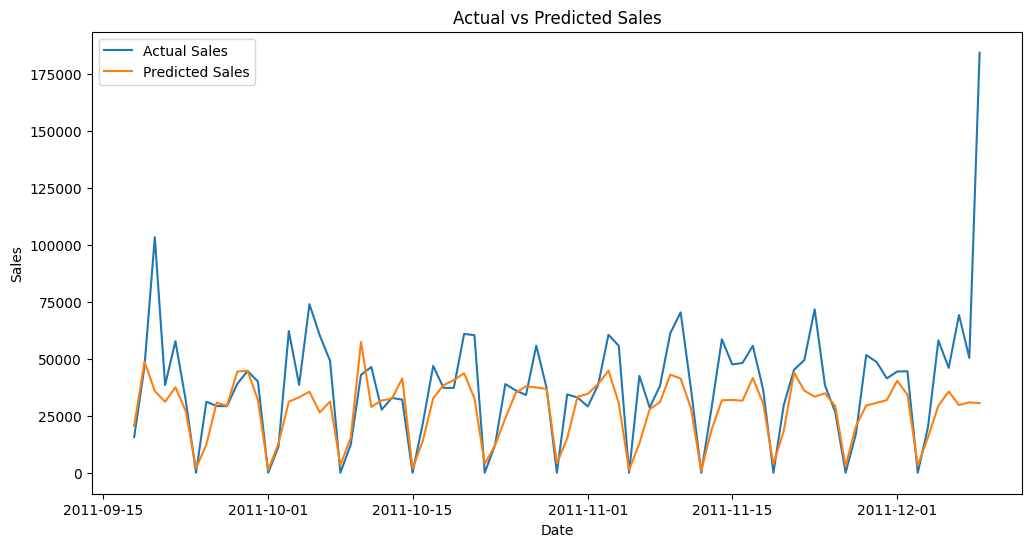

In [10]:
# Plot the results
plt.figure(figsize=(12,6))
plt.plot(test['InvoiceDate'], y_test, label='Actual Sales')
plt.plot(test['InvoiceDate'], predictions, label='Predicted Sales')
plt.legend()
plt.title('Actual vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [11]:
# Save the model
joblib.dump(model, 'sales_forecasting_model.pkl')

['sales_forecasting_model.pkl']